<a href="https://colab.research.google.com/github/nipuni1313/CNN-for-image-classification/blob/main/2_SOTA_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import os

drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/RealWaste_D'  # Update this path

print(os.listdir(dataset_path))  # Should show folders for each class


Mounted at /content/drive
['Miscellaneous Trash', 'Paper', 'Textile Trash', 'Glass', 'Cardboard', 'Food Organics', 'Plastic', 'Metal', 'Vegetation']


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Parameters
IMG_SIZE = 128  # Resize images to 128x128
BATCH_SIZE = 32

# Create Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.4,  # 60% train, 20% validation, 20% test
    horizontal_flip=True,
    zoom_range=0.2,
    rotation_range=10
)

# Load training, validation, and test data
train_data = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

val_data = val_test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training'
)

test_data = val_test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation'
)

# Get the number of classes
num_classes = train_data.num_classes
print(f"Number of Classes: {num_classes}")

Found 2907 images belonging to 9 classes.
Found 2423 images belonging to 9 classes.
Found 2419 images belonging to 9 classes.
Number of Classes: 9


Define ResNet50 Model

In [ ]:
def load_resnet50(input_shape, num_classes):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the convolutional base

    # Add custom classification head
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

Define VGG16 model

In [ ]:
def load_vgg16(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the convolutional base

    # Add custom classification head
    x = Flatten()(base_model.output)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    return model

Training

In [ ]:
def train_model(model, train_data, val_data, learning_rate=0.001, epochs=20):
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    history = model.fit(train_data, validation_data=val_data, epochs=epochs)
    return history

In [ ]:
# Define input shape
input_shape = (IMG_SIZE, IMG_SIZE, 3)

In [ ]:
# Train ResNet50
resnet50_model = load_resnet50(input_shape, num_classes)
resnet50_history = train_model(resnet50_model, train_data, val_data)

Epoch 1/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 394s 4s/step - accuracy: 0.1596 - loss: 2.3454 - val_accuracy: 0.2072 - val_loss: 2.1490
Epoch 2/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 377s 4s/step - accuracy: 0.1888 - loss: 2.1447 - val_accuracy: 0.2134 - val_loss: 2.1252
Epoch 3/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.1819 - loss: 2.1321 - val_accuracy: 0.2109 - val_loss: 2.0857
Epoch 4/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.1832 - loss: 2.1244 - val_accuracy: 0.2295 - val_loss: 2.0852
Epoch 5/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 375s 4s/step - accuracy: 0.1938 - loss: 2.1232 - val_accuracy: 0.2534 - val_loss: 2.1132
Epoch 6/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 415s 5s/step - accuracy: 0.1984 - loss: 2.1025 - val_accuracy: 0.2303 - val_loss: 2.0638
Epoch 7/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 376s 4s/step - accuracy: 0.2102 - loss: 2.0856 - val_accuracy: 0.2196 - val_loss: 2.0441
Epoch 8/20
91/91 ━━━━━━━━━━━━━━━━━━━━ 419s 5s/step - accuracy: 0.2003 - loss: 2.1139 - val_accuracy: 0.2485 - v

In [ ]:
# Train VGG16
vgg16_model = load_vgg16(input_shape, num_classes)
vgg16_history = train_model(vgg16_model, train_data, val_data)


Evaluate models

In [ ]:
# Evaluate ResNet50
resnet50_test_loss, resnet50_test_acc = resnet50_model.evaluate(test_data)
print(f"ResNet50 Test Accuracy: {resnet50_test_acc * 100:.2f}%")

# Evaluate VGG16
vgg16_test_loss, vgg16_test_acc = vgg16_model.evaluate(test_data)
print(f"VGG16 Test Accuracy: {vgg16_test_acc * 100:.2f}%")

Visualizing results

In [ ]:
def plot_loss(history, title):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Plot for ResNet50
plot_loss(resnet50_history, "ResNet50 Loss")

# Plot for VGG16
plot_loss(vgg16_history, "VGG16 Loss")

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

ValueError: mount failed

In [3]:
from google.colab import drive
import os

drive.mount('/content/drive')

dataset_path = '/content/drive/My Drive/RealWaste_D'  # Update this path

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [9]:
# Parameters
IMG_SIZE = 224  # Resize images to 224x224
BATCH_SIZE = 32

# Create a list of class names
class_names = sorted(os.listdir(dataset_path))

In [10]:
# Data Generators
datagen = ImageDataGenerator(
    rescale=1./255,      # Normalize pixel values to [0, 1]
    validation_split=0.4 # Use 40% for validation + test, and 60% for training
)

In [11]:
# Training Data
train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # Sparse labels for integer encoding
    subset='training',
    shuffle=True
)

Found 2907 images belonging to 9 classes.


In [12]:
# Validation/Test Data Generator
val_test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.5)

# Validation Data
val_data = val_test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='training',
    shuffle=False
)

Found 2423 images belonging to 9 classes.


In [13]:
# Test Data
test_data = val_test_datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 2419 images belonging to 9 classes.


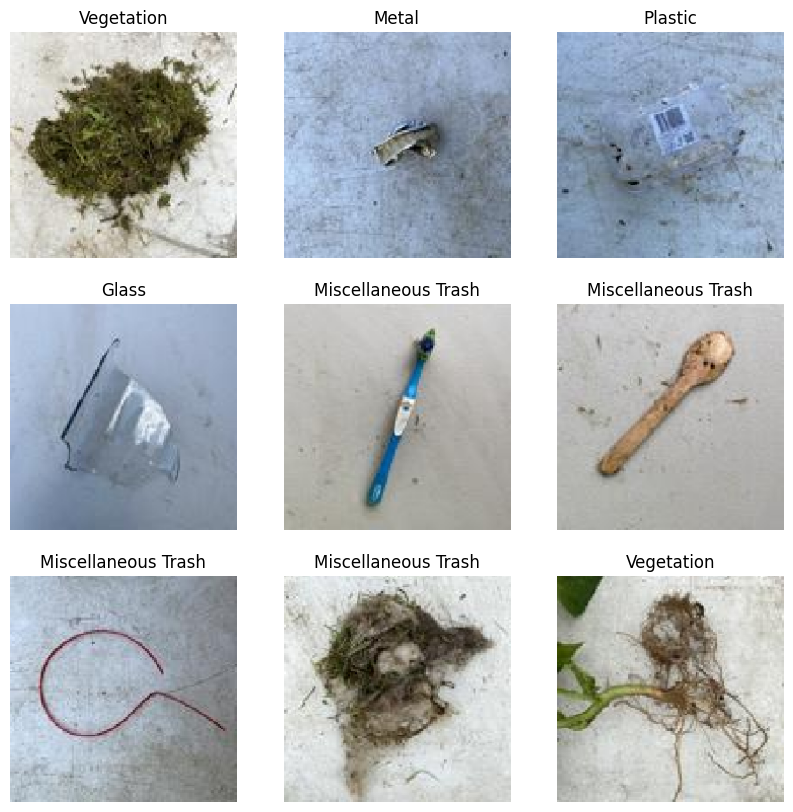

In [15]:
import matplotlib.pyplot as plt

# Retrieve one batch of data
images, labels = next(train_data)  # Use .next() to get a batch

# Visualize the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(class_names[int(labels[i])])  # Convert label to int for indexing
    plt.axis("off")
plt.show()


In [17]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (IMG_SIZE, IMG_SIZE) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [19]:
image_batch, label_batch = next(iter(train_data))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


In [20]:
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [26]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

ValueError: Input 0 of layer "mobilenetv2_1.00_224" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 160, 160, 3)

In [25]:
len(model.trainable_variables)

NameError: name 'model' is not defined